<a href="https://colab.research.google.com/github/kundajelab/dragonn/blob/master/tutorials/Tutorial%201%20-%20Exploring%20model%20architectures%20for%20a%20homotypic%20motif%20density%20simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train your DragoNN tutorial 1: 
## Exploring convolutional neural network (CNN) architectures for simulated genomic data

This tutorial is a supplement to the DragoNN manuscript and follows figure 5 in the manuscript. 

This tutorial will take 20 - 30 minutes if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Review of patterns in transcription factor binding sites</a></li>
    <li><a href=#3>Learning to localize homotypic motif density</a></li>
    <li><a href=#4>Simulate training data with simdna</a></li>  
    <li><a href=#4.5>Running dragonn on your own data: starting with FASTA files</a></li>
    <li><a href=#5>Defining CNN architecture</a></li>
    <li><a href=#6>Single layer, single filter model</a></li>
    <li><a href=#7>Single layer, multiple filter model</a></li>
    <li><a href=#8>Model Interpretation</a></li>    
    <li><a href=#9>Multi-layer model</a></li>
    <li><a href=#10>Regularized multi-layer model</a></li>
    <li><a href=#11>Comparison of DragoNN to LSGKM </a></li>
    <li><a href=#12>Further exploration</a></li>    
    <li><a href=#13>Using DragoNN command-line interface</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/play_button.png?raw=1)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/play_all_button.png?raw=1)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/inspecting_code.png?raw=1)


In [0]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.7

In [0]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [0]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Key properties of regulatory DNA sequences <a name='2'>
<a href=#outline>Home</a>

![sequence properties 1](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/sequence_properties_1.jpg?raw=1)
![sequence properties 2](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/sequence_properties_2.jpg?raw=1)

## Learning to localize homotypic motif density <a name='3'>
<a href=#outline>Home</a>

In this tutorial we will learn how to localize a homotypic motif cluster. We will simulate a positive set of sequences with multiple instances of a motif in the center and a negative set of sequences with multiple motif instances positioned anywhere in the sequence:
![homotypic motif density localization](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/homotypic_motif_density_localization.jpg?raw=1)
We will then train a binary classification model to classify the simulated sequences. To solve this task, the model will need to learn the motif pattern and whether instances of that pattern are present in the central part of the sequence.

![classification task](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/homotypic_motif_density_localization_task.jpg?raw=1)

We start by getting the simulation data.

## Getting simulation data <a name='4'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. We will use the **simulate_motif_density_localization** function to simulate homotypic motif density localization. First, we obtain documentation for the simulation parameters.

In [0]:
from dragonn.simulations import * 

In [0]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a TAL1 motif density localization in 1500bp long sequence, with 0.4 GC fraction, and 2-4 instances of the motif in the central 150bp for the positive sequences. We simulate a total of 3000 positive and 3000 negative sequences.

In [0]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1500,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the **get_simulation_data** function with the simulation name and the simulation parameters as inputs. 1000 sequences are held out for a test set, 1000 sequences for a validation set, and the remaining 4000 sequences are in the training set.

In [0]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
<img src="https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/one_hot_encoding.png?raw=1" width="500">

Here are the first 10bp of a sequence in our training data:

In [0]:
simulation_data.X_train[0, :, :10, :]

array([[[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]])

We can convert this one-hot-encoded matrix back into a DNA string:

In [0]:
simulation_data.X_train.shape

(4000, 1, 1500, 4)

In [0]:
from dragonn.utils import *
get_sequence_strings(simulation_data.X_train)[0][0:10]

'AAGTGCAAAA'

Let's examine the shape of training, validation, and test matrices: 

In [0]:
print(simulation_data.X_train.shape)
print(simulation_data.y_train.shape)

(4000, 1, 1500, 4)
(4000, 1)


In [0]:
print(simulation_data.X_valid.shape)
print(simulation_data.y_valid.shape)

(1000, 1, 1500, 4)
(1000, 1)


In [0]:
print(simulation_data.X_test.shape)
print(simulation_data.y_test.shape)

(1000, 1, 1500, 4)
(1000, 1)


## Running dragonn on your own data: starting with FASTA files <a name='4.5'>
<a href=#outline>Home</a>

If you are running Dragonn on your own data, you can provide data in FASTA sequence format. We recommend generating 6 fasta files for model training: 
* Training positives 
* Training negatives 
* Validation positives 
* Validation negatives 
* Test positives 
* Test negatives 

To indicate how this could be done, we export the one-hot-encoded matrices from **simulation_data** to a FASTA file, and then show how this fasta file could be loaded back to a one-hot-encoded matrix.

In [0]:
from dragonn.utils import fasta_from_onehot

#get the indices of positive and negative sequences in the training, validation, and test sets 
train_pos=np.nonzero(simulation_data.y_train==True)
train_neg=np.nonzero(simulation_data.y_train==False)
valid_pos=np.nonzero(simulation_data.y_valid==True)
valid_neg=np.nonzero(simulation_data.y_valid==False)
test_pos=np.nonzero(simulation_data.y_test==True)
test_neg=np.nonzero(simulation_data.y_test==False)

#Generate fasta files
fasta_from_onehot(np.expand_dims(simulation_data.X_train[train_pos],axis=1),"X.train.pos.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_valid[valid_pos],axis=1),"X.valid.pos.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_test[test_pos],axis=1),"X.test.pos.fasta")

fasta_from_onehot(np.expand_dims(simulation_data.X_train[train_neg],axis=1),"X.train.neg.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_valid[valid_neg],axis=1),"X.valid.neg.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_test[test_neg],axis=1),"X.test.neg.fasta")

Let's examine "X.train.pos.fasta" to verify that it's in the standard FASTA format. 

In [0]:
! head X.train.pos.fasta

>0
AAGTGCAAAAAACAGACAAGATGGGTACAACGTTATCCAACGTGAGTAAATAGCTGATGAAACAGGCAGCTTTTCTCTGAATCAGAAATATACAGGTTTCCGCACCTATTTGTATAGAAGCGAACGTTCTGAGGTATGAATACGATGATAATGACTAACAGAAGTGTTTGCAGAGCGGGTGATTCCGCGTATTTCGCCAACAAGATAACATCAAGCAAATCAAGTTTACCGCTGCTGAGTGATATATAAAGGGATTCACTTAATCGTTTGTATAATTTGAGAGCAGTTATTCTACTACAACTGATTCATTACCTAAACTATGTTTATATCATCCCCAGCAAATTTATTCTTTGTAAAGTAATTAAAAAATACTTCACCCACTAATCTATATATTTTATGAAATCCATGATGTTCCTAATGTGTCAGACCCGGATCTCACACGGATGAGAGAGTTGGACACTGTTGATGCATTGATACAGGGAAAGTGTAAGACTATCGAAGAGCCTTCCAATGTCAGATTTAATCGTACAATTGAATTGTCTTATAACTCATGAGCCTTTTCCAAGAGAGTCTCATCGGCCATACTTTGATATCGTGTTGTAATTCACAAAGCTAGAAATAGGGGGATGTAAGCTCCCGATATTCTTATCCTAATAGGCTTAGTCAGACCAGTCGAACAGTCCAGCTGCCTACGCGTACTCATAGAGTCCTGGCCACCTGCTACATGCGTGGGCAAGCTATCACGGCAAGGTCCTGTATCGCCACCTGCTCGGCTTCCCTGAAGATGAAGATGCTGGTCAATGAAAAGTGCTATGATAGCATACGAACCTGTATTTAATCGATCTAACCATGTGTGAGTTCATTAACTCTTGGGCATATGTTTTCTTGATTCCTGCTTGTGCTTTCTGTTCTTTGAAAACGTATGTTCTTCTTATCTATGACTCCTTAGCAAAACATAATGATACACCTCTTAATACGCTAAAATAGATATGTAGTG

We can then load fasta format data to generate training, validation, and test splits for our models:

In [0]:
from dragonn.utils import encode_fasta_sequences
X_train_pos=encode_fasta_sequences("X.train.pos.fasta")
X_train_neg=encode_fasta_sequences("X.train.neg.fasta")
X_valid_pos=encode_fasta_sequences("X.valid.pos.fasta")
X_valid_neg=encode_fasta_sequences("X.valid.neg.fasta")
X_test_pos=encode_fasta_sequences("X.test.pos.fasta")
X_test_neg=encode_fasta_sequences("X.test.neg.fasta")

X_train=np.concatenate((X_train_pos,X_train_neg),axis=0)
X_valid=np.concatenate((X_valid_pos,X_valid_neg),axis=0)
X_test=np.concatenate((X_test_pos,X_test_neg),axis=0)


In [0]:
y_train=np.concatenate((np.ones(X_train_pos.shape[0]),
                        np.zeros(X_train_neg.shape[0])))
y_valid=np.concatenate((np.ones(X_valid_pos.shape[0]),
                        np.zeros(X_valid_neg.shape[0])))
y_test=np.concatenate((np.ones(X_test_pos.shape[0]),
                        np.zeros(X_test_neg.shape[0])))


Now, having read in the FASTA files, converted them to one-hot-encoded matrices, and defined label vectors, we are ready to train our model. 

# Defining the convolutional neural network model architecture  <a name='5'>
<a href=#outline>Home</a>

A locally connected linear unit in a CNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thresholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a CNN model with tiled, locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thresholding and maxpooling (part c).
![dragonn vs pssm](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/dragonn_and_pssm.jpg?raw=1)
By utilizing multiple convolutional layers with multiple convolutional filters, CNN's can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/dragonn_model_figure.jpg?raw=1)

We will use the deep learning library [keras](http://keras.io/) with the [TensorFlow](https://github.com/tensorflow/tensorflow) backend to generate and train the CNN models. 

In [0]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


Using TensorFlow backend.


# Single layer, single filter model <a name='6'>
<a href=#outline>Home</a>


We define a simple DragoNN model with one convolutional layer with one convolutional filter, followed by maxpooling of width 35. 

The model parameters are: 

* Input sequence length 1500 
* 1 filter: this is a neuron that acts as a local pattern detector on the input profile. 
* Convolutional filter width =  10: this metric defines the dimension of the filter weights; the model scans the entire input profile for a particular pattern encoded by the weights of the filter. 
* Max pool of width 35: computes the maximum value per-channel in sliding windows of size 35. We add the pooling layer becase DNA sequences are typically sparse in terms of the number of positions in the sequence that harbor TF motifs. The pooling layer allows us to reduce the size of the output profile of convolutional layers by employing summary statistics. 

In [0]:
#Define the model architecture in keras
one_filter_keras_model=Sequential() 
one_filter_keras_model.add(Conv2D(filters=1,kernel_size=(1,10),padding="same",input_shape=simulation_data.X_train.shape[1::]))
one_filter_keras_model.add(BatchNormalization(axis=-1))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling2D(pool_size=(1,35)))
one_filter_keras_model.add(Flatten())
one_filter_keras_model.add(Dense(1))
one_filter_keras_model.add(Activation("sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
one_filter_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1500, 1)        41        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1500, 1)        4         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1500, 1)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 42, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [0]:
##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
one_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

We train the model for 150 epochs, with an early stopping criterion -- if the loss on the validation set does not improve for five consecutive epochs, the training is halted. In each epoch, the one_filter_dragonn performed a complete pass over the training data, and updated its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the performance metrics for the one_filter_dragonn on the validation data were stored. 

The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [0]:
from dragonn.callbacks import * 
#We define a custom callback to print training and validation metrics while training. 
metrics_callback=MetricsCallback(train_data=(simulation_data.X_train,simulation_data.y_train),
                                 validation_data=(simulation_data.X_valid,simulation_data.y_valid))


In [0]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_one_filter=one_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 2s 484us/step - loss: 0.7299 - val_loss: 0.7330
Training Data:
Loss: 0.7234	Balanced Accuracy: 50.59%	 auROC: 0.514	 auPRC Careful: 0.496	 auPRC Trapezoidal: 0.496
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7330	Balanced Accuracy: 48.50%	 auROC: 0.490	 auPRC Careful: 0.522	 auPRC Trapezoidal: 0.521
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 73us/step - loss: 0.7208 - val_loss: 0.7277
Training Data:
Loss: 0.7170	Balanced Accuracy: 51.27%	 auROC: 0.519	 auPRC Careful: 0.500	 auPRC Trapezoidal: 0.500
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7277	Balanced Accuracy: 49.00%	 auROC: 0.493	 auPRC Careful: 0.524	 au

4000/4000 [==============================] - 0s 70us/step - loss: 0.6898 - val_loss: 0.6998
Training Data:
Loss: 0.6894	Balanced Accuracy: 54.23%	 auROC: 0.553	 auPRC Careful: 0.539	 auPRC Trapezoidal: 0.539
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.6%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6998	Balanced Accuracy: 50.82%	 auROC: 0.521	 auPRC Careful: 0.552	 auPRC Trapezoidal: 0.550
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 18/150
4000/4000 [==============================] - 0s 73us/step - loss: 0.6894 - val_loss: 0.6966
Training Data:
Loss: 0.6889	Balanced Accuracy: 54.10%	 auROC: 0.554	 auPRC Careful: 0.541	 auPRC Trapezoidal: 0.541
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.5%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6966	Balanced Accuracy: 51.16%	 auROC: 0.525	 auPRC Careful: 0.553	 auPRC Trapezoidal: 0.551
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 528	 Num Negatives: 472
Epo

4000/4000 [==============================] - 0s 71us/step - loss: 0.5448 - val_loss: 0.5198
Training Data:
Loss: 0.5266	Balanced Accuracy: 76.03%	 auROC: 0.846	 auPRC Careful: 0.833	 auPRC Trapezoidal: 0.833
	Recall at 5%|10%|20% FDR: 9.5%|37.6%|68.6%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.5198	Balanced Accuracy: 76.60%	 auROC: 0.861	 auPRC Careful: 0.865	 auPRC Trapezoidal: 0.865
	Recall at 5%|10%|20% FDR: 15.2%|50.0%|76.9%	 Num Positives: 528	 Num Negatives: 472
Epoch 35/150
4000/4000 [==============================] - 0s 70us/step - loss: 0.4933 - val_loss: 0.4594
Training Data:
Loss: 0.4755	Balanced Accuracy: 80.34%	 auROC: 0.884	 auPRC Careful: 0.873	 auPRC Trapezoidal: 0.873
	Recall at 5%|10%|20% FDR: 26.7%|52.6%|79.5%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.4594	Balanced Accuracy: 80.76%	 auROC: 0.896	 auPRC Careful: 0.901	 auPRC Trapezoidal: 0.900
	Recall at 5%|10%|20% FDR: 31.1%|57.4%|88.1%	 Num Positives: 528	 Num Negativ

4000/4000 [==============================] - 0s 69us/step - loss: 0.1918 - val_loss: 0.1996
Training Data:
Loss: 0.1916	Balanced Accuracy: 92.00%	 auROC: 0.979	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 84.9%|94.9%|99.4%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.1996	Balanced Accuracy: 91.02%	 auROC: 0.976	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 84.3%|94.1%|99.6%	 Num Positives: 528	 Num Negatives: 472
Epoch 67/150
4000/4000 [==============================] - 0s 75us/step - loss: 0.1907 - val_loss: 0.1947
Training Data:
Loss: 0.1896	Balanced Accuracy: 92.51%	 auROC: 0.979	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 84.7%|95.0%|99.4%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.1947	Balanced Accuracy: 91.28%	 auROC: 0.976	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 84.7%|94.7%|99.6%	 Num Positives: 528	 Num Negati

### Evaluate the model on the held-out test set 

In [0]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=one_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.2081	Balanced Accuracy: 91.06%	 auROC: 0.974	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 85.6%|93.6%|98.3%	 Num Positives: 515	 Num Negatives: 485


### Visualize the model's performance

We can see that the validation loss is not decreasing and the auROC metric is not decreasing, which indicates this model is not learning. A simple plot of the learning curve, showing the loss function on the training and validation data over the course of training, demonstrates this visually:

In [0]:
#import functions foro visualization of data 
from dragonn.vis import *


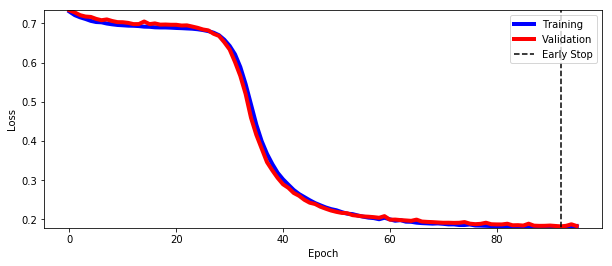

In [0]:
plot_learning_curve(history_one_filter)

## Visualize the learned parameters 

Next, let's visualize the filter learned in this model

### Dense layer

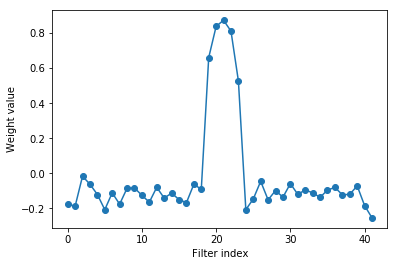

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7fb5300f4630>])

In [0]:
from dragonn.vis import * 
plot_model_weights(one_filter_keras_model)

### Convolutional layer 

In [0]:
W_conv, b_conv = one_filter_keras_model.layers[0].get_weights()

In [0]:
W_conv.shape

(1, 10, 4, 1)

In [0]:
b_conv.shape

(1,)

Plotting simulation motifs...


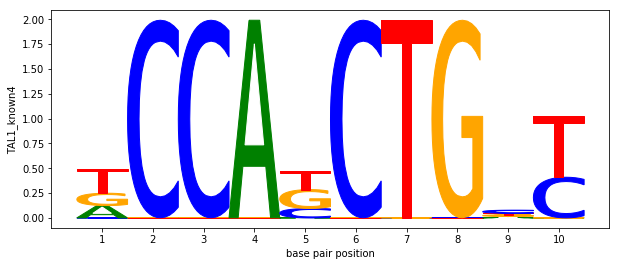

Visualizing convolutional sequence filters in SequenceDNN...


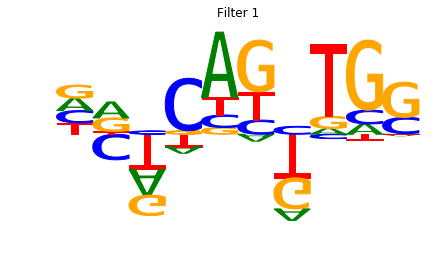

In [0]:
plot_filters(one_filter_keras_model, simulation_data)

# A multi-filter DragoNN model <a name='7'>
<a href=#outline>Home</a>

Next, we modify the model to have 15 convolutional filters instead of just one filter. Will the model learn now?

In [0]:
#Define the model architecture in keras
multi_filter_keras_model=Sequential() 
multi_filter_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_filter_keras_model.add(BatchNormalization(axis=-1))
multi_filter_keras_model.add(Activation('relu'))
multi_filter_keras_model.add(MaxPooling2D(pool_size=(1,35)))
multi_filter_keras_model.add(Flatten())
multi_filter_keras_model.add(Dense(1))
multi_filter_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [0]:
multi_filter_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1491, 15)       60        
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 630)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 631       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total para

In [0]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_filter=multi_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 1s 217us/step - loss: 0.8386 - val_loss: 0.7250
Training Data:
Loss: 0.7245	Balanced Accuracy: 51.82%	 auROC: 0.532	 auPRC Careful: 0.511	 auPRC Trapezoidal: 0.510
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7250	Balanced Accuracy: 52.35%	 auROC: 0.525	 auPRC Careful: 0.550	 auPRC Trapezoidal: 0.549
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 83us/step - loss: 0.7224 - val_loss: 0.7214
Training Data:
Loss: 0.7019	Balanced Accuracy: 54.40%	 auROC: 0.565	 auPRC Careful: 0.539	 auPRC Trapezoidal: 0.538
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7214	Balanced Accuracy: 52.28%	 auROC: 0.540	 auPRC Careful: 0.561	 auPRC Trapezoidal: 0.560
	Recall at 5%|10%|20% FDR

4000/4000 [==============================] - 0s 81us/step - loss: 0.2526 - val_loss: 0.2822
Training Data:
Loss: 0.2434	Balanced Accuracy: 93.12%	 auROC: 0.980	 auPRC Careful: 0.978	 auPRC Trapezoidal: 0.978
	Recall at 5%|10%|20% FDR: 86.2%|96.0%|99.2%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.2822	Balanced Accuracy: 89.29%	 auROC: 0.961	 auPRC Careful: 0.963	 auPRC Trapezoidal: 0.963
	Recall at 5%|10%|20% FDR: 74.8%|90.2%|97.5%	 Num Positives: 528	 Num Negatives: 472
Epoch 18/150
4000/4000 [==============================] - 0s 82us/step - loss: 0.2395 - val_loss: 0.2735
Training Data:
Loss: 0.2302	Balanced Accuracy: 93.34%	 auROC: 0.981	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 88.0%|96.5%|99.4%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.2735	Balanced Accuracy: 89.26%	 auROC: 0.963	 auPRC Careful: 0.965	 auPRC Trapezoidal: 0.965
	Recall at 5%|10%|20% FDR: 76.1%|90.5%|97.9%	 Num Positives: 528	 Num Negati

In [0]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.2054	Balanced Accuracy: 91.28%	 auROC: 0.975	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 87.4%|93.2%|98.6%	 Num Positives: 515	 Num Negatives: 485


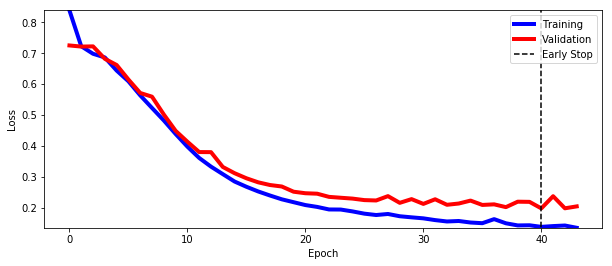

In [0]:
## Visualize the model's performance 
plot_learning_curve(history_multi_filter)

Plotting simulation motifs...


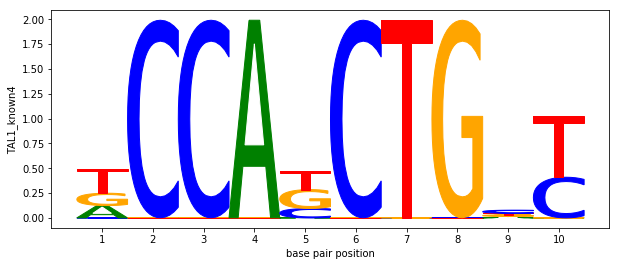

Visualizing convolutional sequence filters in SequenceDNN...


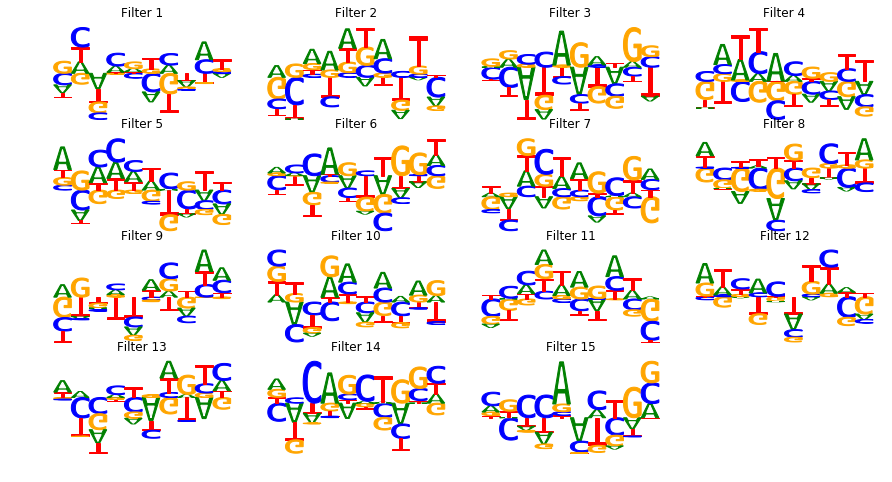

In [0]:
## Visualize the motifs learned by the model
plot_filters(multi_filter_keras_model, simulation_data)

# Model Interpretation <a name='8'>
<a href=#outline>Home</a>


As you can see, the filters/model parameters are difficult to be interepreted directly. However, there are alternative approaches of interepreting sequences.

Let's examine a positive and negative example from our simulation data:

In [0]:
#get the indices of the first positive and negative examples in the validation data split
pos_indx=np.flatnonzero(simulation_data.y_valid==1)[0]
print(pos_indx)
pos_X=simulation_data.X_valid[pos_indx:pos_indx+1]

neg_indx=np.flatnonzero(simulation_data.y_valid==0)[10]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

2
14


### Motif Scores

In [0]:
from dragonn.utils import * 
pos_motif_scores=get_motif_scores(pos_X,simulation_data.motif_names,return_positions=True)
neg_motif_scores=get_motif_scores(neg_X,simulation_data.motif_names,return_positions=True)

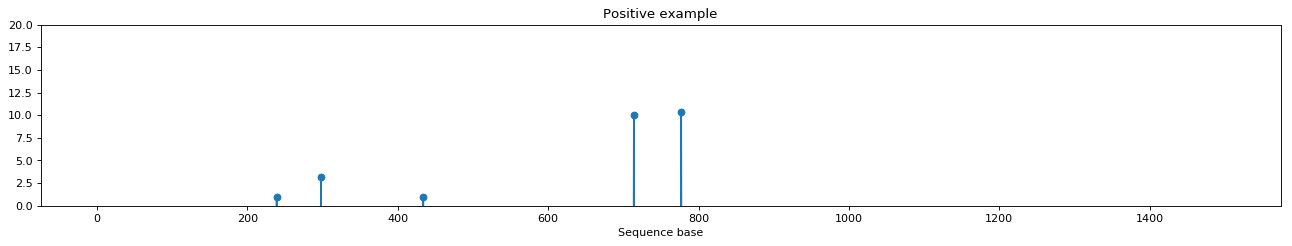

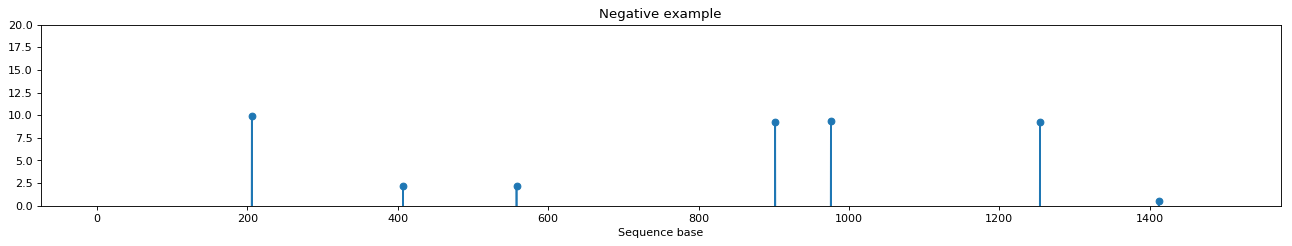

In [0]:
from dragonn.vis import * 
plot_motif_scores(pos_motif_scores,title="Positive example",ylim=(0,20))
plot_motif_scores(neg_motif_scores,title="Negative example",ylim=(0,20))

The motif scan yields a group of three high-scoring motif alignment positions at a fixed distance near the center of the sequence in the positive example. The spacing of the high-scoring motif alignments is random in the negative sequence. 

Note: If you find that your negative example is too close to the positive examle (i.e. the randomly spaced motifs happen to have a spacing close to the positive example, feel free to provide another index value to select a different negative). 

For example, you can change the code to select a negative example to the below: 


In [0]:
neg_indx=np.flatnonzero(simulation_data.y_valid==0)[10]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

14


### *In silico* mutagenesis 

To determine how much each position in the input sequence contrinbutes to the model's prediction, we can perform saturation mutagenesis on the sequence. For each position in the input sequence, we introduce each of the four possible bases A, C, G, T and quantify the effect on the model's predictions.

*In silico* mutagenesis entails measuring the effect of a given base pair on the model's prediction of accessibility. The following algorithm is used: 

1. At each position in the input sequence, the reference allele is mutated to each of three possible alternate alleles, and the model predictions with the alternate alleles are obtained. 

2. The logit values for the reference allele are subtracted from the logit values for each of the 4 alleles. (This means that a difference of 0 will be obtained for the reference allele). We refer to these differences in logit at each position between the reference and alternate alleles as the ISM values. ISM values are computed in logit space to avoid any saturation effects from passing the logits through a sigmoid function. 

3. For each position, subtract the mean ISM value for that position from each of the 4 ISM values. 

4. Plot the 4xL heatmap of mean-normalized ISM values 

5. Identity the highest scoring (mean subtracted) allele at each position. 

In [0]:
pos_X.shape

(1, 1, 1500, 4)

In [0]:
from dragonn.interpret.ism import *
ism_pos=in_silico_mutagenesis(multi_filter_keras_model,pos_X,0)
ism_neg=in_silico_mutagenesis(multi_filter_keras_model,neg_X,0)

ISM: task:0 sample:0
ISM: task:0 sample:0


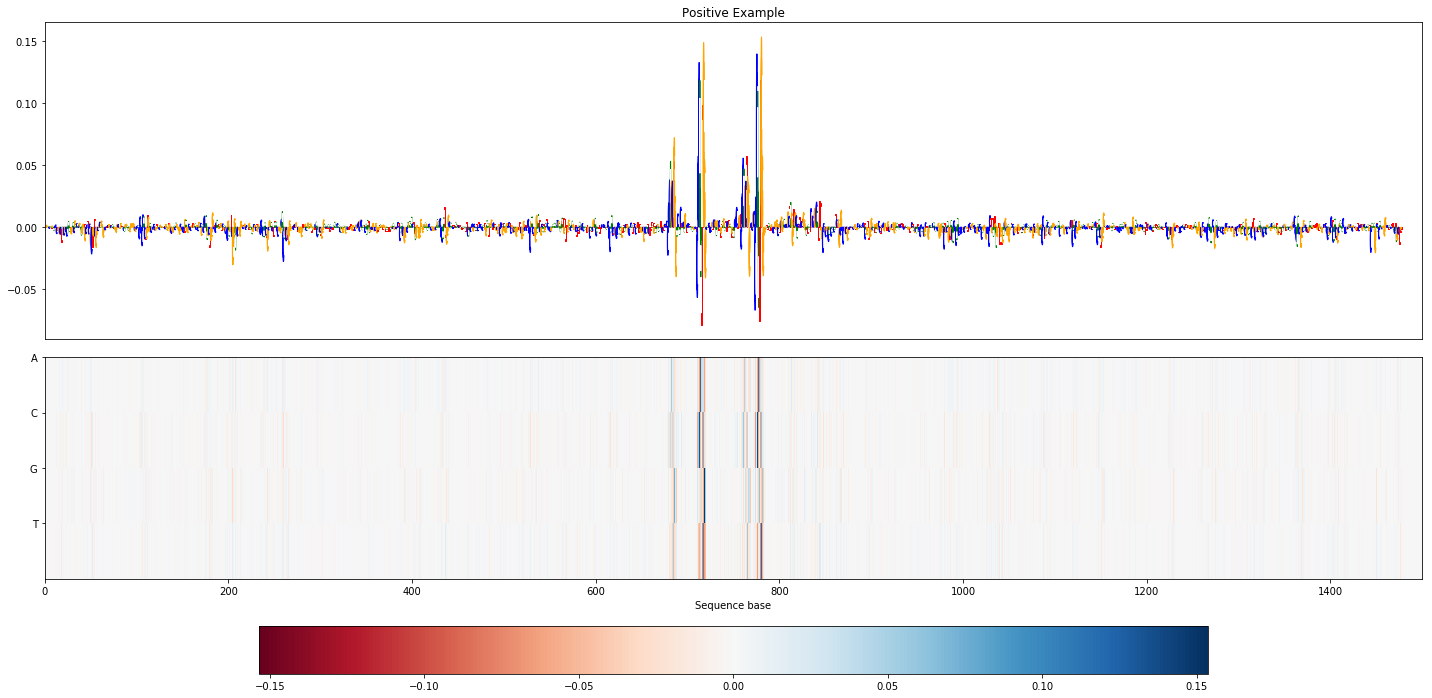

In [0]:
from dragonn.vis import * 
# create discrete colormap of ISM scores 
plot_ism(ism_pos,title="Positive Example")


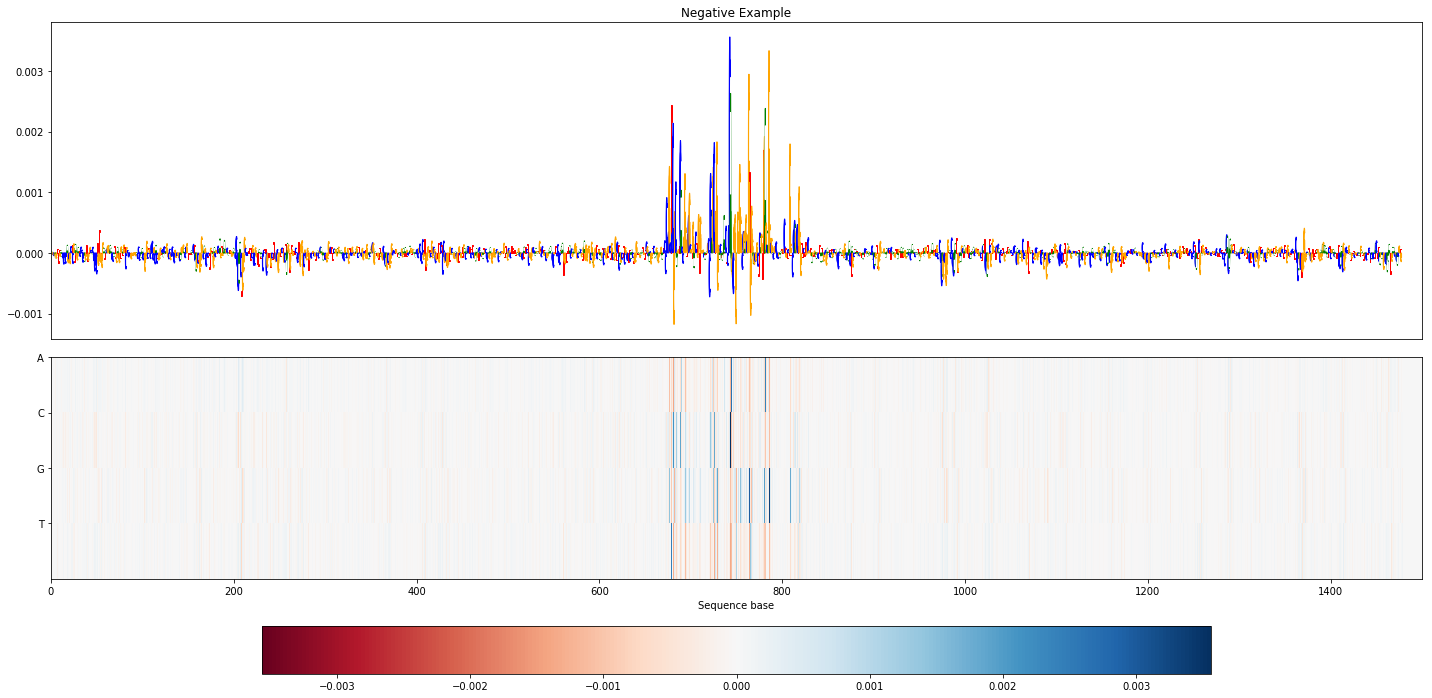

In [0]:
plot_ism(ism_neg,title="Negative Example")

### Gradient x Input 

Consider a neural net being a function: $f(x_1, ..., x_N; w) = y$

One way to tell whether the input feature is important is to compute the gradient of the function with respect to (w.r.t.) model input: $\frac{\partial f}{\partial x_i}$

This approach is called saliency maps: "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", by Karen Simonyan, Andrea Vedaldi and Andrew Zisserma https://arxiv.org/pdf/1312.6034.pdf

In genomics, we typically visualize only gradients for bases observed in the sequence (called input masked gradients or input*grad).

In [0]:
from dragonn.interpret.input_grad import * 
gradinput_pos=input_grad(multi_filter_keras_model,pos_X)
gradinput_neg=input_grad(multi_filter_keras_model,neg_X)

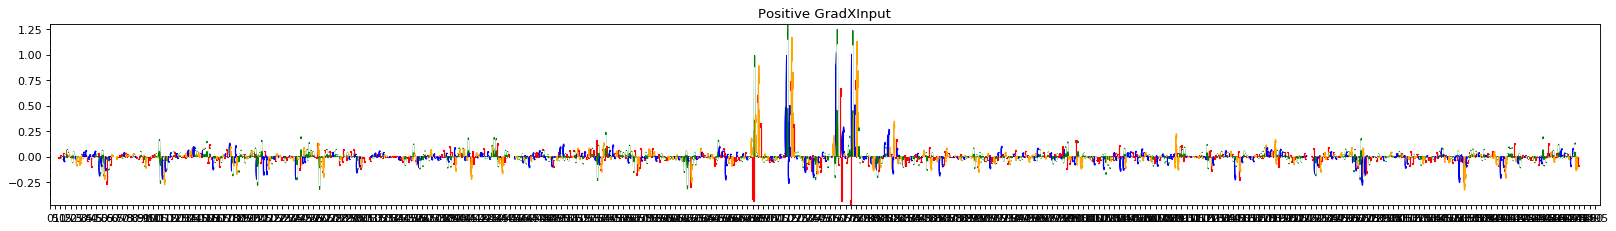

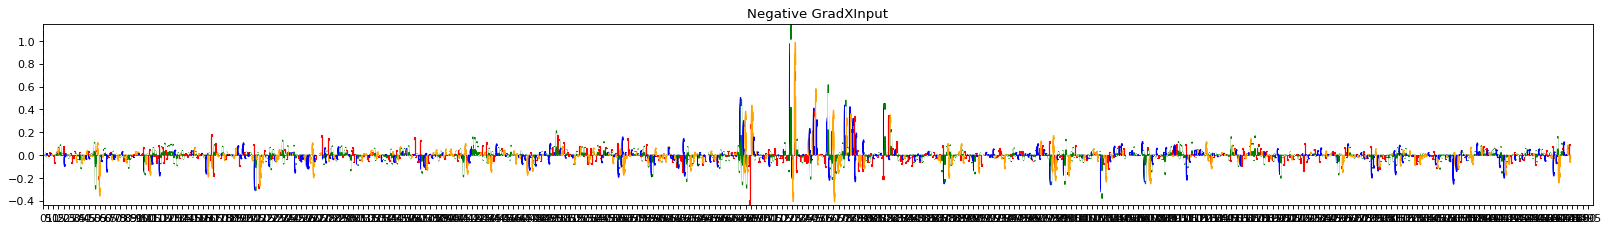

In [0]:
from dragonn.vis import plot_seq_importance
plot_seq_importance(gradinput_pos,pos_X,title="Positive GradXInput")
plot_seq_importance(gradinput_neg,neg_X,title="Negative GradXInput")


Let's zoom in to the center 150 bp of the sequence, where the simulated homotypic motif grammar is to be found. 

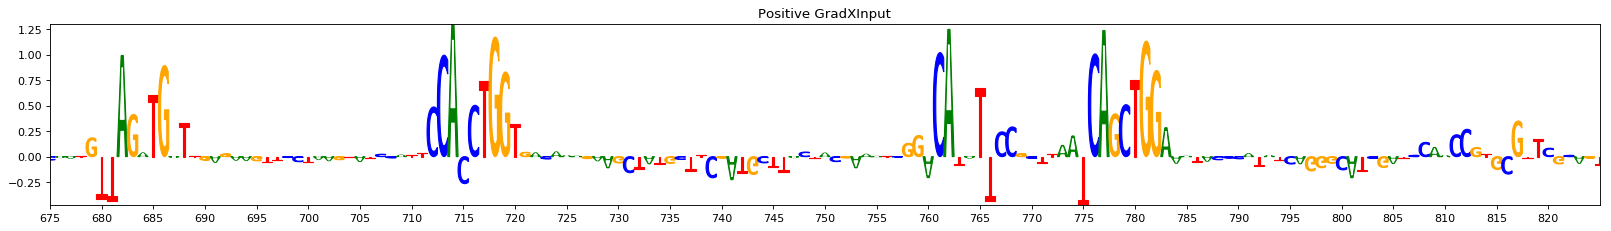

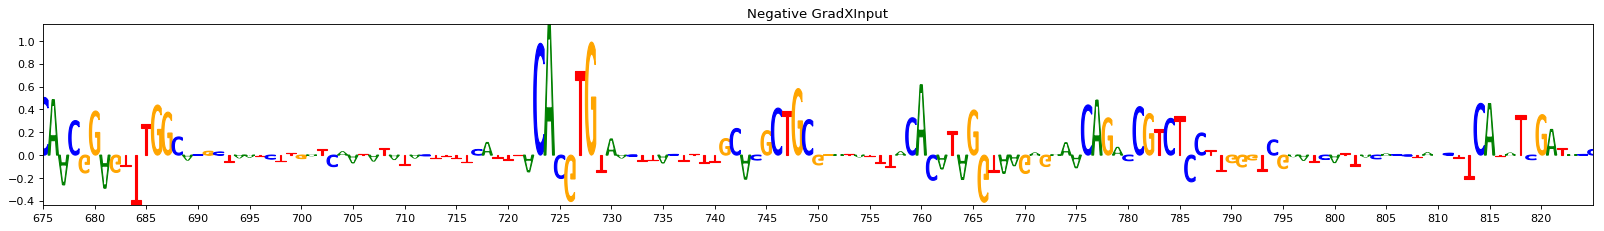

In [0]:
plot_seq_importance(gradinput_pos,pos_X,title="Positive GradXInput",xlim=(675,825))
plot_seq_importance(gradinput_neg,neg_X,title="Negative GradXInput",xlim=(675,825))

### DeepLIFT

[DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf) allows us to obtain scores for specific sequence indicating the importance of each position in the sequence. DeepLIFT can accept a custom reference. For our purposes, we provide a dinucleotide-shuffled reference. 

We can now load the saved model for use in other applications or for further fine-tuning:

In [0]:
from dragonn.interpret.deeplift import * 
#note that the defaults for the deeplift function use 10 shuffled references per input sequence 
help(deeplift)

Help on function deeplift in module dragonn.interpret.deeplift:

deeplift(score_func, X, batch_size=200, task_idx=0, num_refs_per_seq=10, reference='shuffled_ref', one_hot_func=None)
    Arguments: 
        score_func -- deepLIFT scoring function 
        X -- numpy array with shape (n_samples, 1, n_bases_in_sample,4) or list of FASTA sequences 
        batch_size -- number of samples to interpret at once 
        task_idx -- index indicating which task to perform interpretation on 
        reference -- one of 'shuffled_ref','gc_ref','zero_ref'
        num_refs_per_seq -- integer indicating number of references to use for each input sequence if the reference is set to 'shuffled_ref';if 'zero_ref' or 'gc_ref' is used, this argument is ignored.
        one_hot_func -- one hot function to use for encoding FASTA string inputs; if the inputs are already one-hot-encoded, use the default of None 
    Returns:
        (num_task, num_samples, 1, num_bases, sequence_length) deeplift score array.

### Saving a keras model 


We save the optimal regularized multi-layer keras model to an hdf5 file that contains both the model weights and architecture.

In [0]:
multi_filter_keras_model.save("tut1_multi_filter_keras_model.hdf5")


We can now load the saved model for use in other applications or for further fine-tuning:

In [0]:
from keras.models import load_model
model=load_model("tut1_multi_filter_keras_model.hdf5")

We first use the saved model to obtain the DeepLIFT scoring function. We use a shuffled reference, with 10 shuffled reference sequences for each example. 

In [0]:
dl_score_func=get_deeplift_scoring_function('tut1_multi_filter_keras_model.hdf5',
                                           target_layer_idx=-2,
                                           task_idx=0,
                                           num_refs_per_seq=10,
                                           reference='shuffled_ref',
                                           one_hot_func=None)

In [0]:
#We use the scoring function to calculate deepLIFT scores for the positive and negative examples 
dl_pos=deeplift(dl_score_func,pos_X)
dl_neg=deeplift(dl_score_func,neg_X)

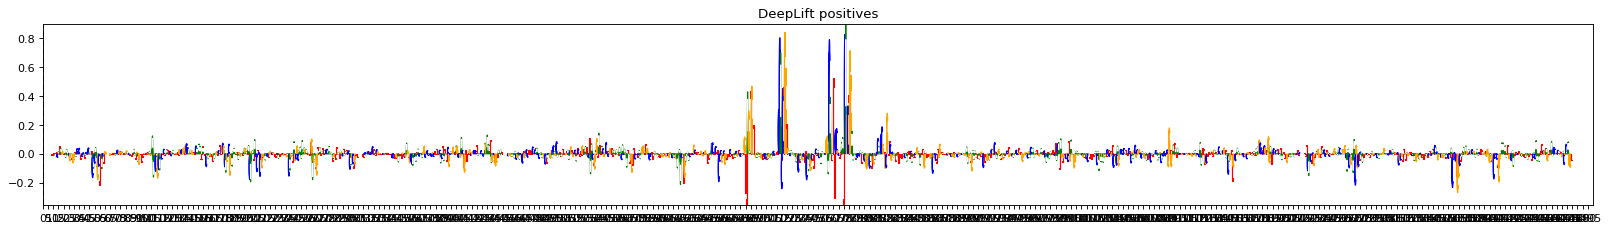

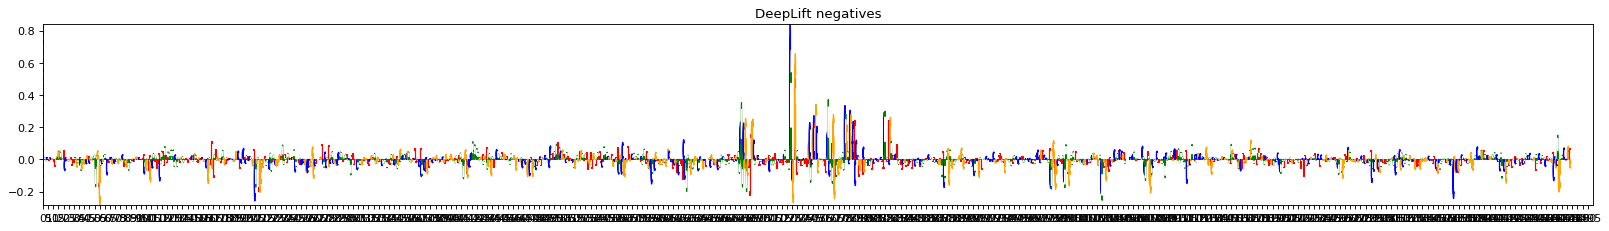

In [0]:
plot_seq_importance(dl_pos,pos_X,title="DeepLift positives")
plot_seq_importance(dl_neg,neg_X,title="DeepLift negatives") 

Zooming in to the 150 bases at the center of the sequence: 

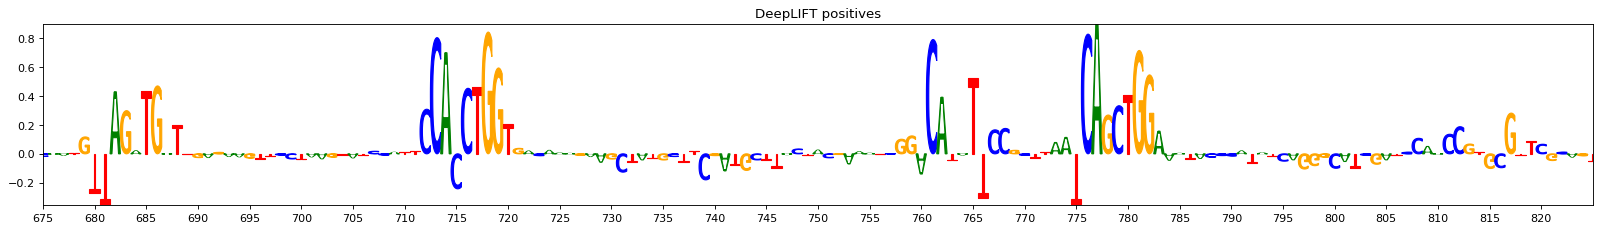

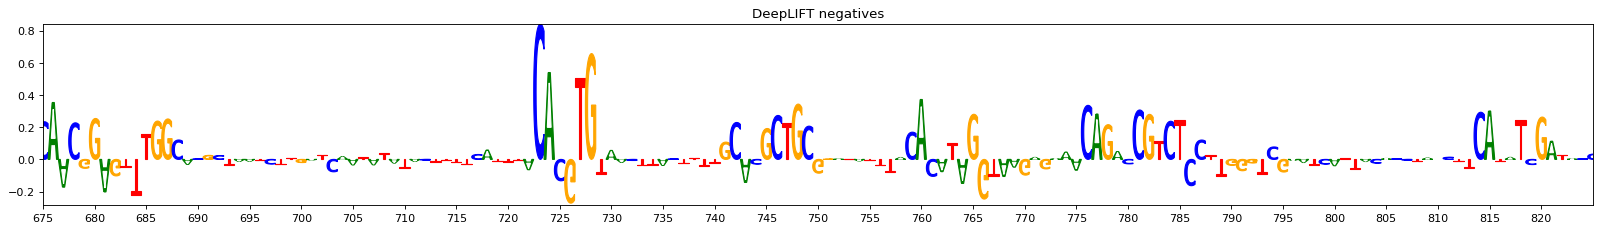

In [0]:
plot_seq_importance(dl_pos,pos_X,title="DeepLIFT positives",xlim=(675,825))
plot_seq_importance(dl_neg,neg_X,title="DeepLIFT negatives",xlim=(675,825))

# A multi-layer DragoNN model <a name='9'>

<a href=#outline>Home</a> 

Next, we train a 3 layer model for this task. Will it outperform the single layer model and to what extent will it overfit?

In [0]:
#Define the model architecture in keras
multi_layer_keras_model=Sequential() 
multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))

multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))

multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))
multi_layer_keras_model.add(MaxPooling2D(pool_size=(1,35)))


multi_layer_keras_model.add(Flatten())
multi_layer_keras_model.add(Dense(1))
multi_layer_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_layer_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

multi_layer_keras_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
activation_5 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1482, 15)       2265      
_________________________________________________________________
activation_6 (Activation)    (None, 1, 1482, 15)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1473, 15)       2265      
_________________________________________________________________
activation_7 (Activation)    (None, 1, 1473, 15)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 42, 15)         0         
__________

In [0]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_layer=multi_layer_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150


ResourceExhaustedError: OOM when allocating tensor with shape[128,15,1,1482] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_3/Adam/gradients/conv2d_5_1/convolution_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [0]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_layer_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

In [0]:
## Visualize the model's performance 
plot_learning_curve(history_multi_layer)

We export the new model to hdf5 to allow for subsequent interpretation with DeepLIFT. 

In [0]:
multi_layer_keras_model.save("tut1_multi_layers_keras_model.hdf5")


Dragonn provides a single utility function to interpret and plot model predictions through all the methodologies we have examined: 
    * Plots the motif scores (when available) to serve as a "gold standard" for interpretation
    * Plots the ISM heatmap and sequence importance track 
    * Plots the gradient x input importance track
    * Plots the DeepLIFT importance track 
    

In [0]:
from dragonn.interpret import *
help(multi_method_interpret)

In [0]:
#To run multi_method_interpret, we first need to obtain the deepLIFT scoring function: 
dl_score_func_multi_layer=get_deeplift_scoring_function("tut1_multi_layers_keras_model.hdf5")

In [0]:
pos_interpretations=multi_method_interpret(multi_layer_keras_model,
                                           pos_X,
                                           0,
                                           dl_score_func_multi_layer,
                                           motif_names=simulation_data.motif_names)

In [0]:
neg_interpretations=multi_method_interpret(multi_layer_keras_model,
                                           neg_X,
                                           0,
                                           dl_score_func_multi_layer,
                                           motif_names=simulation_data.motif_names)

Zooming in to the center of the sequence: 

In [0]:
plot_all_interpretations([pos_interpretations],pos_X,xlim=(650,850))

In [0]:
plot_all_interpretations([neg_interpretations],neg_X,xlim=(650,850))

This model performs slightly better than the single layer model but it overfits more. We will try to address that with dropout regularization.

# A regularized multi-layer DragoNN model <a name='10'>
    
<a href=#outline>Home</a> 
    
Next, we regularize the 3 layer using 0.2 dropout on every convolutional layer. Will dropout improve validation performance?

In [0]:
#Define the model architecture in keras

regularized_keras_model=Sequential() 
regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))
regularized_keras_model.add(MaxPooling2D(pool_size=(1,35)))


regularized_keras_model.add(Flatten())
regularized_keras_model.add(Dense(1))
regularized_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
regularized_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

regularized_keras_model.summary() 

In [0]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_regularized=regularized_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


In [0]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=regularized_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

In [0]:
## Visualize the model's performance 
plot_learning_curve(history_regularized)

### Interpreting regularized, multi-layer model 

In [0]:
regularized_keras_model.save("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

In [0]:
#obtain the deepLIFT scoring function for interpretation 
dl_score_func_multi_layer_regularized=get_deeplift_scoring_function("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

In [0]:
pos_interpretations=multi_method_interpret(regularized_keras_model,
                                           pos_X,
                                           0,
                                           dl_score_func_multi_layer_regularized,
                                           motif_names=simulation_data.motif_names)

In [0]:
neg_interpretations=multi_method_interpret(regularized_keras_model,
                                           neg_X,
                                           0,
                                           dl_score_func_multi_layer_regularized,
                                           motif_names=simulation_data.motif_names)

We now plot the interpretation scores for pos_X and neg_X along the full sequence as well as along the central 200 bp.

In [0]:
plot_all_interpretations([pos_interpretations],pos_X,xlim=(650,850))

In [0]:
plot_all_interpretations([neg_interpretations],neg_X,xlim=(650,850))

As expected, dropout decreased the overfitting this model displayed previously and increased test performance. Let's see the learned filters.

## Comparison to LSGKM 
<a href=#outline>Home</a> 

We would like to compare the performance of DragoNN against similar tools that use classical machine learning approaches to learn patterns of transcription factor binding sequences. LSGKM (https://github.com/Dongwon-Lee/lsgkm) uses an approach based on support vector machines to solve this task. The algorithm is described in: 

* Ghandi, M.†, Lee, D.†, Mohammad-Noori, M. & Beer, M. A. Enhanced Regulatory Sequence Prediction Using Gapped k-mer Features. PLoS Comput Biol 10, e1003711 (2014). doi:10.1371/journal.pcbi.1003711 † Co-first authors

* Lee, D. LS-GKM: A new gkm-SVM for large-scale Datasets. Bioinformatics btw142 (2016). doi:10.1093/bioinformatics/btw142

Now, we will install LSGKM and see how it compares to DragoNN in predicting homotypic motif density patterns. 


In [0]:
#The following steps will install lsgkm on your system. Alternatively, you can follow the instructions presented here: 
# https://github.com/Dongwon-Lee/lsgkm#installation
!git clone https://github.com/Dongwon-Lee/lsgkm
%cd lsgkm/src 
!ls
!make
!make install 



In [0]:
#check to see that the install completed successfully 
%cd ../../
!lsgkm/bin/gkmtrain

In [0]:
#Run gkmtrain on the positive and negative FASTA sequences we extracted earlier. We use 16 threads, you can 
# increase/decrease that number as your system allows
!lsgkm/bin/gkmtrain -T 16 X.train.pos.fasta X.train.neg.fasta gkmTrainOut 

In [0]:
#Use gkmpredict to get predictions on the positive test set 
!./lsgkm/bin/gkmpredict -T 16 X.test.pos.fasta gkmTrainOut.model.txt gkmTestOut.pos.txt 

In [0]:
#Use gkmpredict to get predictions on the negative test set 
!./lsgkm/bin/gkmpredict -T 16 X.test.neg.fasta gkmTrainOut.model.txt gkmTestOut.neg.txt 

In [0]:
#Computue lsgkm performance on the test set
import pandas as pd
lsgkm_predictions_pos_test_set=pd.read_table('gkmTestOut.pos.txt',header=None,sep='\t',index_col=0)
lsgkm_predictions_neg_test_set=pd.read_table('gkmTestOut.neg.txt',header=None,sep='\t',index_col=0)


In [0]:
#add in the data labels of 1 (positive) and 0 (negative)
lsgkm_predictions_pos_test_set[2]=1
lsgkm_predictions_neg_test_set[2]=0
#merge the dataframes into a single frame 
lsgkm_predictions=pd.concat([lsgkm_predictions_pos_test_set,lsgkm_predictions_neg_test_set])
lsgkm_predictions.reset_index()
lsgkm_predictions.columns=['Prediction','Label']


In [0]:
#let's plot the lsgkm predictions 
f=plt.figure(figsize=(20,5))
plt.scatter(lsgkm_predictions.index,lsgkm_predictions["Prediction"],s=30,c=lsgkm_predictions['Label'])

This looks pretty good! Most of the samples in the positive test set (blue dots) have prediction scores greater than 0, while most of the samples in the negative test set (red dots) have prediction scores less than 0. We now quantify LSGKM's performance in the same manner we did for DragoNN. 

In [0]:
labels=np.expand_dims(np.asarray(lsgkm_predictions['Label'].astype('bool')),axis=1)
predictions=np.expand_dims(np.asarray(lsgkm_predictions['Prediction']),axis=1)
print(ClassificationResult(labels,predictions))

We compare side-by-side with the regularized, multi-layer model: 

In [0]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=regularized_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

The DragoNN model outperforms LSGKM on this dataset according to all metrics examined. One caveat is that we spent some time searching for the optimal hyperparameters to use with the DragoNN model -- we tweaked the number of filters, the numbers of layers, and added regularization. We did not perform the same hyperparameter tuning on LSGKM. Try running LSGKM with different values of the tunable parameters (-l, -k, -d, -g, -C) to determine whether DragoNN outperforms LSGKM in all cases or not.  

## For further exploration<a name='11'>
<a href=#outline>Home</a>

In this tutorial we explored modeling of homotypic motif density. Other properties of regulatory DNA sequence include
![sequence properties 3](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/sequence_properties_3.jpg?raw=1)
![sequence properties 4](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/sequence_properties_4.jpg?raw=1)

DragoNN provides simulations that formulate learning these patterns into classification problems:
![sequence](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/sequence_simulations.png?raw=1)

You can view the available simulation functions by running print_available_simulations:

In [0]:
print_available_simulations()

## Using DragoNN command line interface. <a name='12'>
<a href=#outline>Home</a>

The DragoNN toolkit provides a command line interface for training classification models on FASTA files. The default architecture for the command line interface is the multi-layer regularized architecture we just explored. However, there is the option to modify hyperparameters such as the number of tasks, the number of filters, the number of layers, convolution width filter, pooling width, amount of L1 regularization, and the amount of dropout. An example of using the command line interface to train a model, predict on test data, and interpret the predictions with DeepLIFT is provided below. 